In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import seaborn as sns
sns.set_theme(style="ticks", font_scale=1.5)
import os
import json
from datetime import datetime
import inspect
import os
import sys
import importlib
import matplotlib.gridspec as gridspec
import pandas as pd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors


sys.path.append('../Classes')

import sgh_class
importlib.reload(sgh_class)
import sgh_class

import colorsys
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

# %matplotlib widget

In [5]:
size = 300

x = sgh_class.SGH_class(tree_root_active=0, shading_active=1)
p = np.linspace(0.01, 800/180, size)
c = np.linspace(0, 1, size)

N_p = len(p)
N_c = len(c)
# c_values = [0.4, 0.9]

B_results = np.full((N_p, N_c), np.nan)

run_code = False

if run_code:
    # shading
    for i, precip in enumerate(p):
        for j, c_val in enumerate(c):
            print(f"p={precip*180:.1f} mm/yr, c={c_val:.2f}")
            B_results[i, j] = x.solutions_fast(p=precip, c=c_val)[0] * 1000  # convert to g
    # sol0 = []; sol1 = []; sol2 = []
    # for precip in p:
    #     sol0.append(x.solutions_fsolve(p=precip, c=0))
    #     sol1.append(x.solutions_fsolve(p=precip, c=c_values[0]))
    #     sol2.append(x.solutions_fsolve(p=precip, c=c_values[1]))
    # combined_array = np.hstack([p.reshape(-1, 1), np.array(sol0), np.array(sol1), np.array(sol2)])
    # combined_array[:,[1,3,5]] *= 1000  # convert biomass from kg to g
    np.savetxt('B_results_c01.csv', B_results)
    np.savetxt('p_c_arrays_c01.csv', np.c_[p, c])

B_results = np.loadtxt('B_results_c01.csv')
p_c_arrays = np.loadtxt('p_c_arrays_c01.csv')
p = p_c_arrays[:, 0]
c = p_c_arrays[:, 1]
# data_tree_root = np.loadtxt('tree_root.csv')
# data_shading = np.loadtxt('shading.csv')

In [6]:
b_no_trees = B_results[:, 0]
B_collapse_mask = B_results<1e-4  # mask where biomass is effectively zero
# B_abs = B_results - b_no_trees[:, np.newaxis]
B_rel = np.log(B_results / b_no_trees[:, np.newaxis])

B_abs = B_results - b_no_trees[:, np.newaxis]
B_abs[B_collapse_mask] = np.nan

B_black = np.zeros_like(B_abs)
B_black[~B_collapse_mask] = np.nan

/var/folders/jm/7q3bqdxj5bs8tn13m8qn22kr0000gn/T/ipykernel_37591/4074386593.py:4: RuntimeWarning: divide by zero encountered in log
  B_rel = np.log(B_results / b_no_trees[:, np.newaxis])



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


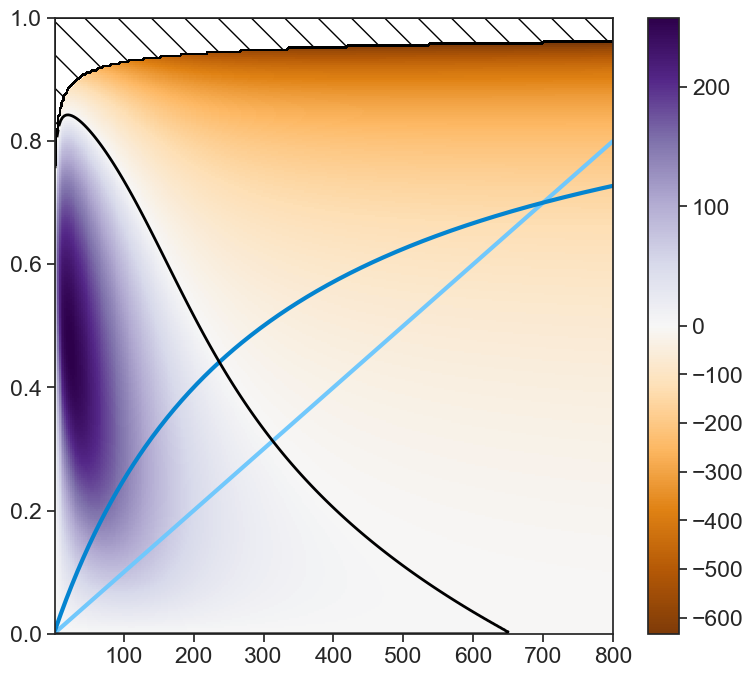

In [8]:
%pip install palettable

B_results[B_results< 0.0] = 0.0
red = ['#fda2b7', '#d10333', '#6c011a']
blue = ['#71c8fc', '#0484d0', '#02456c']
fig, ax = plt.subplots(figsize=(9, 8))

div_cmap = plt.get_cmap('seismic')
from palettable.colorbrewer.diverging import PuOr_11
div_cmap = PuOr_11.mpl_colormap

vmin = float(np.nanmin(B_abs))
vmax = float(np.nanmax(B_abs))
norm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

im = ax.imshow(
    B_abs.T,
    cmap=div_cmap,
    norm=norm,
    # alpha=0.9,
    extent=[180*p.min(), 180*p.max(), c.min(), c.max()],
    aspect='auto',
    origin='lower',
    interpolation='nearest'
)
cbar = fig.colorbar(im, ax=ax)

# Overlay B_black with hatching for collapsed regions
# ax.imshow(
#     B_black.T,
#     cmap='gray',
#     extent=[180*p.min(), 180*p.max(), c.min(), c.max()],
#     aspect='auto',
#     origin='lower',
#     interpolation='nearest',
#     alpha=0,  # Make the overlay transparent
# )
# Add hatching using contour for collapsed regions
collapsed_mask = np.isnan(B_black.T)
h = ax.contourf(
    180*p, c, ~collapsed_mask,
    levels=[0.5, 1.5],
    colors='white',
    hatches=['\\'],
    extent=[180*p.min(), 180*p.max(), c.min(), c.max()],
    origin='lower'
)
h.set_edgecolor('black')


p180 = p * 180.0
c1 = p180 / 1000.0
c2 = p180 / (300 + p180)

ax.plot(p180, c1, color=blue[0], linestyle='-', linewidth=3)
ax.plot(p180, c2, color=blue[1], linestyle='-', linewidth=3)

exp_levels = [0]
# Make a mesh in plotting units for contour
PP, CC = np.meshgrid(p*180, c)
CS = ax.contour(PP, CC, B_abs.T, levels=exp_levels, colors='black', linestyles='-', linewidths=2)
# ax.clabel(CS, levels=exp_levels, inline=True, fmt='%d', fontsize=12, colors='k')


In [9]:
import numpy as np

def find_horizontal_ridges(data_matrix):
    """
    Finds coordinates of local maxima along the rows (horizontal direction).
    A ridge line here would run vertically.
    """
    data = np.asarray(data_matrix)
    
    # 1. Compare with the element to the LEFT (j-1)
    # Pad the matrix with -infinity on the right side to prevent the last column
    # from incorrectly being marked as a max (since it has no right neighbor).
    left_shift = np.hstack([data[:, 1:], data[:, -1:] - 1]) 
    is_greater_than_left = data > left_shift
    
    # 2. Compare with the element to the RIGHT (j+1)
    # Pad the matrix with -infinity on the left side.
    right_shift = np.hstack([data[:, :1] - 1, data[:, :-1]]) 
    is_greater_than_right = data > right_shift

    # A true maximum must be strictly greater than *at least* one neighbor 
    # and greater than or equal to the other to handle flat peaks correctly.
    # For a simple local maximum (peak), we often check: 
    # (data >= left_shift) AND (data >= right_shift) AND (data > left_shift OR data > right_shift)
    
    # Simple check (strict maxima):
    # is_max_mask = (data > left_shift) & (data > right_shift)
    
    # Better check (handles plateaus where data[i,j] = data[i,j-1] > data[i,j+1]):
    is_max_mask = (data >= left_shift) & (data >= right_shift) & \
                  ((data > left_shift) | (data > right_shift))
                  
    # Get the coordinates
    coordinates = np.argwhere(is_max_mask)
    return coordinates

# Example
# data = np.array([[1, 2, 3, 2, 1],
#                  [0, 5, 5, 5, 0],
#                  [9, 1, 9, 1, 9]])
# horizontal_ridges = find_horizontal_ridges(data) 
# The local maxima (3s, 5s, 9s) should be returned

<Figure size 640x480 with 0 Axes>

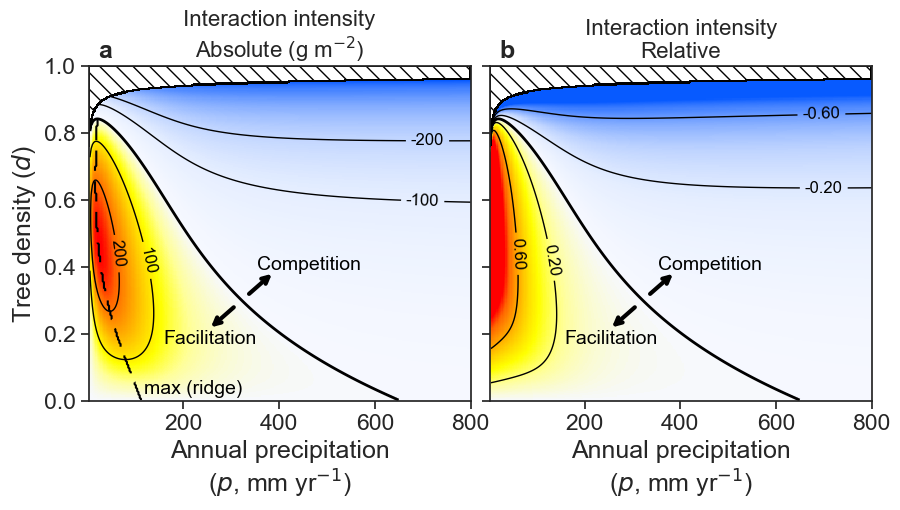

In [10]:
from palettable.scientific.diverging import Berlin_20, Vik_20
from palettable.cartocolors.diverging import Tropic_7
from palettable.colorbrewer.diverging import PuOr_11
from palettable.lightbartlein.diverging import BlueOrangeRed_13
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.clf()
fig, ax = plt.subplots(1,2, figsize=(9, 5), sharey="row")
fig.subplots_adjust(left=0.10, bottom=0.20, right=0.97, top=0.87, wspace=0.05, hspace=0.05)

div_cmap = BlueOrangeRed_13.mpl_colormap
vmin_abs = float(np.nanmin(B_abs))
vmax_abs = float(np.nanmax(B_abs))
norm_abs = colors.TwoSlopeNorm(vmin=vmin_abs, vcenter=0, vmax=vmax_abs)
vmin_rel = -1 #float(np.nanmin(B_rel))
vmax_rel = 1 #float(np.nanmax(B_rel))
norm_rel = colors.TwoSlopeNorm(vmin=vmin_rel, vcenter=0, vmax=vmax_rel)

im0 = ax[0].imshow(
    B_abs.T,
    cmap=div_cmap,
    norm=norm_abs,
    extent=[180*p.min(), 180*p.max(), c.min(), c.max()],
    aspect='auto',
    origin='lower',
    interpolation='nearest'
)

im1 = ax[1].imshow(
    B_rel.T,
    cmap=div_cmap,
    norm=norm_rel,
    extent=[180*p.min(), 180*p.max(), c.min(), c.max()],
    aspect='auto',
    origin='lower',
    interpolation='nearest'
)
exp_levels_abs = [-200,-100, 100, 200]
exp_levels_rel = [-0.6, -0.2, 0.2, 0.6]

# exp_levels_abs = np.arange(-200, 301, 100)
B_abs2 = B_abs.copy()
B_abs2[0, :] = np.nan
B_abs2[:, 0] = np.nan
B_rel2 = B_rel.copy()
B_rel2[0, :] = np.nan
B_rel2[:, 0] = np.nan
# Make a mesh in plotting units for contour
PP, CC = np.meshgrid(p*180, c)
CS0 = ax[0].contour(PP, CC, B_abs2.T, levels=exp_levels_abs, colors='black', linestyles='-', linewidths=1)
manual_positions = [(710, 0.77), (700, 0.6), (123, 0.42),(60, 0.44)]
ax[0].clabel(CS0, levels=exp_levels_abs, inline=True, fmt='%d', fontsize=12, colors='black', manual=manual_positions)

CS1 = ax[1].contour(PP, CC, B_rel2.T, levels=exp_levels_rel, colors='black', linestyles='-', linewidths=1)
manual_positions = [(695, 0.86), (700, 0.6), (123, 0.42),(60, 0.44)]
ax[1].clabel(CS1, levels=exp_levels_rel, inline=True, fmt='%.2f', fontsize=12, colors='black', manual=manual_positions)

CS0b = ax[0].contour(PP, CC, B_abs2.T, levels=[0], colors='black', linestyles='-', linewidths=2)
# ax[0].clabel(CS0b, levels=[0], inline=True, fmt='0', fontsize=12, colors='black', manual=[(300, 0.33)])
ax[1].contour(PP, CC, B_rel2.T, levels=[0], colors='black', linestyles='-', linewidths=2)

ax[0].set(ylabel=r"Tree density ($d$)",
          xlabel='Annual precipitation\n' +r'($p$, mm yr$^{-1}$)',
          )
ax[0].set_title("Interaction intensity\n" r"Absolute (g m$^{-2}$)", fontsize=16)
ax[1].set(xlabel='Annual precipitation\n' +r'($p$, mm yr$^{-1}$)',)
ax[1].set_title("Interaction intensity\n" r"Relative", fontsize=16)

ridge = find_horizontal_ridges(B_abs.T)
filtered_ridge = []
for coord in ridge:
    if (B_abs.T[coord[0], coord[1]] >= 0) and (coord[0]>0):
        filtered_ridge.append(coord)
filtered_ridge = np.array(filtered_ridge)
ax[0].plot(180*p[filtered_ridge[:,1]], c[filtered_ridge[:,0]], color='black', label='Ridge', ls='--', dashes=(10, 5))
ax[0].text(117, 0.02, "max (ridge)", fontsize=14, color='black')

center = [0.40, 0.30]
diag_offset = 0.08

ax[0].annotate(
        '', 
        xy=(center[0]+0.02, center[1]+0.02), 
        xytext=(center[0]+diag_offset, center[1]+diag_offset),
        xycoords='axes fraction',
        textcoords='axes fraction',
        size=12,
        clip_on=False,
        ha='left',
        va='top',
        arrowprops=dict(color='black', arrowstyle="<-", connectionstyle="arc3,rad=0.0", linewidth=3, shrinkA=0, shrinkB=0)
)
ax[0].annotate(
        '', 
        xy=(center[0]-0.02, center[1]-0.02), 
        xytext=(center[0]-diag_offset, center[1]-diag_offset),
        xycoords='axes fraction',
        textcoords='axes fraction',
        size=12,
        clip_on=False,
        ha='left',
        va='top',
        arrowprops=dict(color='black', arrowstyle="<-", connectionstyle="arc3,rad=0.0", linewidth=3, shrinkA=0, shrinkB=0)
)
ax[0].text(0.44, 0.38, 'Competition', fontsize=14, color="black", ha='left', va='bottom', transform=ax[0].transAxes)
ax[0].text(0.44, 0.16, 'Facilitation', fontsize=14, color="black", ha='right', va='bottom', transform=ax[0].transAxes)
ax[1].text(0.44, 0.38, 'Competition', fontsize=14, color="black", ha='left', va='bottom', transform=ax[1].transAxes)
ax[1].text(0.44, 0.16, 'Facilitation', fontsize=14, color="black", ha='right', va='bottom', transform=ax[1].transAxes)


ax[1].annotate(
        '', 
        xy=(center[0]+0.02, center[1]+0.02), 
        xytext=(center[0]+diag_offset, center[1]+diag_offset),
        xycoords='axes fraction',
        textcoords='axes fraction',
        size=12,
        clip_on=False,
        ha='left',
        va='top',
        arrowprops=dict(color='black', arrowstyle="<-", connectionstyle="arc3,rad=0.0", linewidth=3, shrinkA=0, shrinkB=0)
)
ax[1].annotate(
        '', 
        xy=(center[0]-0.02, center[1]-0.02), 
        xytext=(center[0]-diag_offset, center[1]-diag_offset),
        xycoords='axes fraction',
        textcoords='axes fraction',
        size=12,
        clip_on=False,
        ha='left',
        va='top',
        arrowprops=dict(color='black', arrowstyle="<-", connectionstyle="arc3,rad=0.0", linewidth=3, shrinkA=0, shrinkB=0)
)

collapsed_mask = np.isnan(B_black.T)
h = ax[0].contourf(
        180*p, c, ~collapsed_mask,
        levels=[0.5, 1.5],
        colors='white',
        hatches=['\\\\'],
        extent=[180*p.min(), 180*p.max(), c.min(), c.max()],
        origin='lower'
)
h.set_edgecolor('black')
h = ax[1].contourf(
        180*p, c, ~collapsed_mask,
        levels=[0.5, 1.5],
        colors='white',
        hatches=['\\\\'],
        extent=[180*p.min(), 180*p.max(), c.min(), c.max()],
        origin='lower'
)
h.set_edgecolor('black')

ax[0].text(0.025, 1.01, 'a', transform=ax[0].transAxes, fontsize=18, fontweight='bold', va='bottom')
ax[1].text(0.025, 1.01, 'b', transform=ax[1].transAxes, fontsize=18, fontweight='bold', va='bottom')

fig.savefig('interaction_intensity_2d.png', dpi=300)
fig.savefig('interaction_intensity_2d.pdf')